# The Leaky Integrate and Fire(LIF) Neuron Model

####  In this tutorial, we will build up a leaky integrate-and-fire (LIF), exponential leaky integrate-and-fire (ELIF), adaptive exponential leaky integrate and fire (AELIF) neuron model and study their dynamics in response to various types of inputs. 

## Implementation from scratch

### Import Necessary Libraries

In [2]:
import numpy as np
import plotly.express as px
import math

## Leaky Integrate & Fire Model (LIF)
#### formulate
$\tau.\frac{du}{dt} = -(u - u_{rest}) + R.I(t)$, $\Delta u = u - u_{rest}$ ,$I_t = I(t)$

#### Threshhold
$ u(t) = \theta \implies \text{Fire + Reset } (u = u_{rest}) $

In [9]:
"""
Implementation of Leaky Integrate and Fire Neuron Model.
"""
class LIF:

    def __init__(self , parameters:dict):
        self.tau = parameters['tau']
        self.R = parameters['R']
        self.v_reset = parameters['v_reset']
        self.v_rest = parameters['v_rest']
        self.threshold = parameters['threshold']
        self.dt = parameters['dt']
        self.v = self.v_rest

        
    def getdv(self , I):
        return (-(self.v - self.v_rest) + self.R * I) \
                *self.dt / self.tau

    
    def get_minimal_I(self):
        return (self.threshold - self.v_rest) / self.R
    
        
    def new_iteration(self, I):
        spike = 0
        self.v += self.getdv(I)
        if self.v >= self.threshold:
            self.v = self.v_reset
            spike = 1
        return spike
            
            
    
    def simulate(self , I_t , T):
        self.voltage = []
        self.spike_times = []
        for iteration in range(T):
            spike_flag = self.new_iteration(I_t[iteration])
            if spike_flag:
                self.spike_times.append(iteration)
            self.voltage.append(self.v)
        return self.voltage , self.spike_times

## Plotting Functions

In [10]:
def plot_neuron_info(v, I):
    x = range(len(v))
    v_fig = px.line(x=x, y=v, title="Voltage of neuron during the simulation")
    I_fig = px.line(x=x, y=I, title="Input given to neuron")
    v_fig.show()
    I_fig.show()

### Simulate LIF Model

In [11]:
def get_step_input_currents(I_values , I_period):
    I = []
    for value , time in zip(I_values , I_period):
        temp = [value for _ in range(time)]
        I += temp
    return I

### Set input and model parameters

In [12]:
I_values = [0 , 10 , 0]
I_periods = [5 , 30 , 10]
inputI = get_step_input_currents(I_values , I_periods)
config = {
    "v_reset" : -70,
    "v_rest": -70,
    "tau" : 10 ,
    "R" : 2 ,
    "threshold" : -50,
    "dt" : 1
}

In [13]:
neuron = LIF(config)
v , s = neuron.simulate(inputI , sum(I_periods))

In [14]:
plot_neuron_info(v , inputI)

## Exponential LIF Model
#### formulate
$\tau.\frac{du}{dt} = -(u - u_{rest}) + R.I(t) + \Delta_{T}exp(\frac{u - \theta_{rh}}{\Delta_{T}})$

First part describe the leak of a passive membrane same as LIF model.

$\Delta_{T}$ is the sharpness parameter.

$\theta_{rh}$ is the firing threshold.

In [15]:
class ELIF(LIF):

    def __init__(self , parameters:dict):
        super().__init__(parameters)
        self.deltaT = parameters['deltaT']

    def getdv(self , I):
        return ((-(self.v - self.v_rest) + self.R * I) + self.deltaT * math.exp((self.v - self.threshold)/self.deltaT)) * \
        (self.dt / self.tau)
            


## Addaptive Exponential LIF Model
#### formulate
$\tau.\frac{du}{dt} = -(u - u_{rest}) + R.I(t) + \Delta_{T}exp(\frac{u - \theta_{rh}}{\Delta_{T}}) - Rw$

$\tau.\frac{dw}{dt} = a(u - u_{rest}) - w + b \tau_w \sum\limits_{t^f}\sigma(t - t^f)$

- At each threshold crossing, the adaptation variable w is increased by an amount b
- Adaptation is characterized by two parameters:
    - the parameter a is the source of subthreshold adaptation, because it couples adaptation to the voltage
    - spike-triggered adaptation is controlled by a combination of a and b.

In [16]:
class AELIF(LIF):
    
    def __init__(self , parameters):
        super().__init__(parameters)
        self.deltaT = parameters['deltaT']
        self.tau_m = parameters['tau_m']
        self.tau_w = parameters['tau_w']
        self.a = parameters['a']
        self.b = parameters['b']
        self.w = parameters['w']

    
    def getdv(self , I):
        return ((-(self.v - self.v_rest) + self.R * (I - self.w)) \
        + self.deltaT * math.exp((self.v - self.threshold)/self.deltaT)) * self.dt / self.tau_m
    
    
    def getdw(self , t):
        return self.a * (self.v - self.v_rest) - self.w + self.b * self.tau_w * self.spike_times.count(t)
    
    
    def new_iteration(self, I , iteration):
        self.w += self.getdw(iteration)
        spike = super().new_iteration(I)
        return spike
    

### Put Them Together!

In [17]:
def createAndRunModel(model_name , config , duration , plot = False):
    if model_name == "LIF":
        behaviourObj = LIF(config)
    elif model_name == "ELIF":
        behaviourObj = ELIF(config)
    elif model_name == "AELIF":
        behaviourObj = AELIF(config)
    else:
        raise Exception("Invalid model name")
    v , s = behaviourObj.simulate(config['I_t'] , duration)
    if plot:
        plot_neuron_info(v , config['I_t'])
    return v, s

## F-I Curve

In [13]:
def getFICurveData(model_name , config , minI , maxI , duration):
    I_values = []
    f = []
    for current_I in range(minI , maxI+1):
        I_values.append(current_I)
        inputI = get_step_input_currents([current_I] , [duration])
        config['I_t'] = inputI
        voltage , spikes = createAndRunModel(model_name , config , duration)
        if not spikes:
            f.append(0)
        else:    
            f.append(1/(spikes[1]-spikes[0]))
    return I_values , f


def plotFICurve(model_name , config , minI , maxI , duration):
    I , f = getFICurveData(model_name , config , minI , maxI , duration)
    plt.plot(I , f)
    plt.xlabel('I')
    plt.ylabel('f')
    plt.title('frequency-current relation')
    plt.show()
        

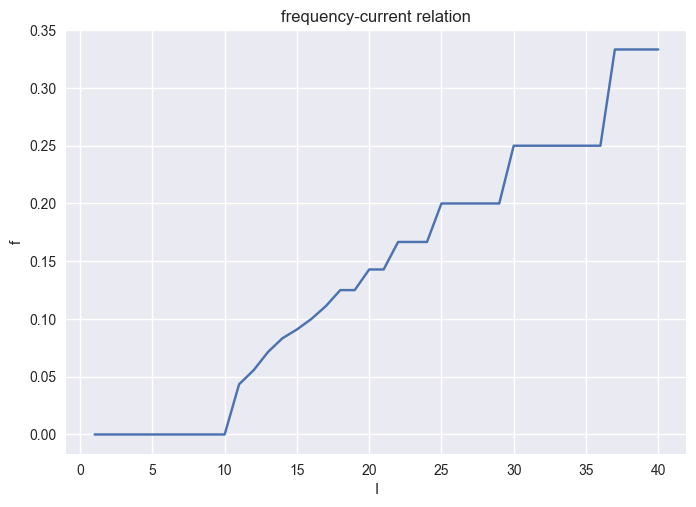

In [14]:
plotFICurve("LIF" , config , 1 , 40 , 200)

## Gaussian white noise

In [15]:
def generateNormalI(mean , std , size):
    return np.random.normal(mean , std , size)

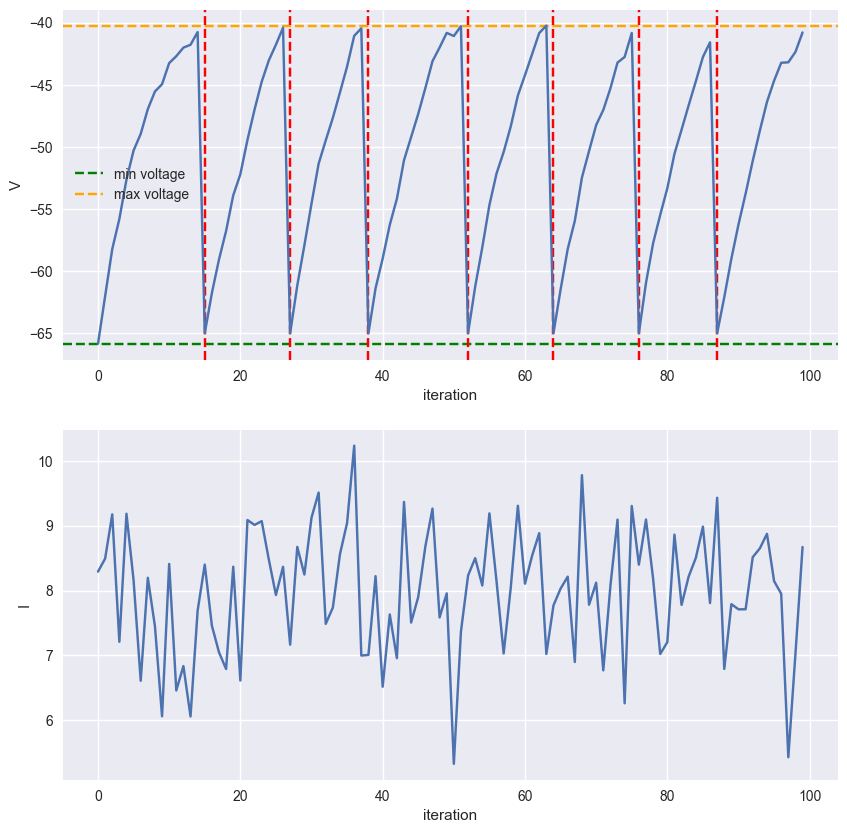

([-65.8546622236837,
  -62.02348416715411,
  -58.23449166440502,
  -55.806208615532604,
  -52.634083469753215,
  -50.29279551909536,
  -48.958906572701515,
  -46.96508368549679,
  -45.54346483116072,
  -44.95823429983747,
  -43.25745789701397,
  -42.701968001326705,
  -42.01420366640982,
  -41.783276685985705,
  -40.75959358238296,
  -65,
  -61.77007200146158,
  -59.069042964637994,
  -56.767122681587665,
  -53.90678454112479,
  -52.20983438377915,
  -49.44564688366561,
  -46.995971075003844,
  -44.761729925705446,
  -43.04633294358039,
  -41.776166944463355,
  -40.41592804602171,
  -65,
  -61.16407311729906,
  -57.92440479816071,
  -54.57102716008892,
  -51.359504111221966,
  -49.480443878570235,
  -47.66404231726912,
  -45.617229044729,
  -43.53473442576682,
  -41.06497215647969,
  -40.459504181502716,
  -65,
  -61.389430605925554,
  -58.99208724823439,
  -56.277407459461315,
  -54.17098179048176,
  -51.071760749225916,
  -49.211558639161126,
  -47.33908515740965,
  -45.2653599208204

In [21]:
params = {
        "v_reset" : -65,
        "v_rest": -70,
        "tau" : 10 ,
        "R" : 5 ,
        "I_t": generateNormalI(8 , 1 , 100),
        "threshold" : -40,
        "dt" : 1
    }
createAndRunModel("LIF" , params , 100 , plot=True)

## coefficient of variation (CV) of the interspike interval (ISI)

In [36]:
def get_ISI(model_name , params , duration):
    v , spike_times = createAndRunModel(model_name , params , duration)
    return np.diff(spike_times)

def CV_ISI(model_name , params , duration):
    isi_values = get_ISI(model_name , params , duration)
    return np.std(isi_values) / np.mean(isi_values)

(array([60.,  9.,  7., 10., 10., 11.,  6.,  2.,  0.,  2.]),
 array([0.        , 0.06901159, 0.13802317, 0.20703476, 0.27604634,
        0.34505793, 0.41406951, 0.4830811 , 0.55209268, 0.62110427,
        0.69011585]),
 <BarContainer object of 10 artists>)

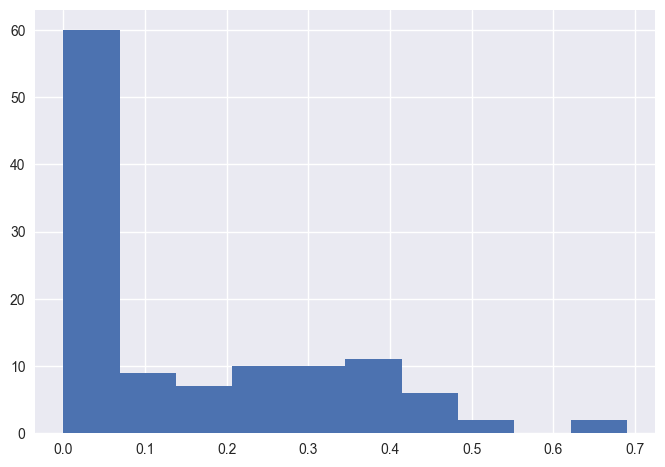

In [43]:
params = {
        "v_reset" : -65,
        "v_rest": -70,
        "tau" : 8 ,
        "R" : 5 ,
        "threshold" : -55,
        "dt" : 1
    }

I_mean = [18 , 21 , 25 , 30 , 33 , 35  , 40 , 42 , 45 , 50 , 53 , 56 , 60]
I_std = [1 , 2 , 4 , 5 , 7 , 10 , 12 , 15 , 18]
duration = 100
isi = []
for curr_mean in I_mean:
    for curr_std in I_std:
        I = generateNormalI(curr_mean , curr_std , duration)
        params["I_t"] = I
        isi.append(CV_ISI("LIF" , params , duration))

plt.hist(isi)
